In [1]:
import dolphindb as ddb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def draw(result):
    fig, axs = plt.subplots(4, figsize=(10, 10))
    result.set_index("trade_time").groupby('grp')['af_rev'].plot(legend=True, ax=axs[0])
    result.set_index("trade_time").groupby('grp')['cumret'].plot(legend=True, ax=axs[1])
    result.set_index("trade_time").groupby('grp')['cumfee'].plot(legend=True, ax=axs[2])
    result.set_index("trade_time").groupby('grp')['cnt'].plot(legend=True, ax=axs[3])
    
def cal_sharpe(ret: pd.Series):
    single_ret = ret.diff().dropna()
    sharpe = single_ret.mean() / single_ret.std() * np.sqrt(365*3)
    return sharpe

def backtest(factor, num = 2):
    def core(num):
        sess = ddb.session(host='localhost', port=8848, userid='admin', password='123456')
        sess.run("factor = table(1000:0,`trade_time`instrument`factor_value, [TIMESTAMP,SYMBOL,DOUBLE])")
        sess.run("tableInsert{factor}",factor.dropna())
        # sess.upload({
        #     'factor': factor,
        #     'num': num
        # })
        sess.upload({'num': num})
        try:
            df: pd.DataFrame = sess.runFile("backtest.dos")
        except Exception as e:
            error_msg = str(e).split('script:')[0]
            print(error_msg)
            raise e
        sess.run('clearAllCache()')
        sess.close()
        return df
    
    df = core(num)    
    return df

In [2]:
import dolphindb as ddb
import pandas as pd


sess = ddb.session(host='localhost', port=8848, userid='admin', password='123456')
sess.runFile('factors/alpha101.dos')
sess.run('''
    instruments = select trade_time as tradetime, instrument as securityid, open, high, low, close, volume as vol from loadTable("dfs://crypto_db", "k_hour")
    ''')
lucky = '''2,1.4317617658091235
6,-1.22331333141334
19,1.7492571361873892
30,1.5846507522690674
37,1.0444579127639086
38,2.2345266919595885
54,1.3956501862195263
60,1.0714170696945486'''
tot = None
for line in lucky.split('\n'):
    parts = line.split(',')
    i = parts[0]
    weight = float(parts[1])
    df: pd.DataFrame = sess.run(f'''
        factor = calAlpha{i}(instruments, 2020.12.01 00:00:00.000, 2024.01.01 00:00:00.000)
        factor = table(factor.rowNames() as trade_time, factor)
        factor = factor.unpivot(`trade_time, factor.columnNames()[1:])
        factor.rename!(`trade_time`instrument`factor_value)
        factor = select timestamp(trade_time) as trade_time, instrument, zscore(factor_value) as factor_value from factor where factor_value is not null
        // factor = select trade_time, instrument, factor_value / max(abs(factor_value)) as factor_value from factor context by trade_time
        select * from factor where trade_time >= 2021.01.01 order by trade_time, instrument
    ''')
    df['factor_value'] = df['factor_value'] * weight
    # result = backtest(df, 2)
    # sharpe = cal_sharpe(result[result['grp']==-1]['cumret'])
    # print(sharpe)
    if tot is not None:
        df = df.rename(columns={'factor_value': f'factor_value_{i}'})
        tot = pd.merge(tot, df, how='left', on=['trade_time', 'instrument'])
    else:
        df = df.rename(columns={'factor_value': f'factor_value_{i}'})
        tot = df
print(tot)
# print(df)
# result = backtest(df, 2)
# sharpe = cal_sharpe(result[result['grp']==-1]['cumret'])
# print(sharpe)
# draw(result)

sess.close()

        trade_time instrument  factor_value_2  factor_value_6  \
0       2021-01-01  1INCHUSDT       -1.770669        2.083382   
1       2021-01-01   AAVEUSDT       -1.177661        1.417770   
2       2021-01-01    ADAUSDT       -0.403767       -0.245699   
3       2021-01-01   ALGOUSDT        0.465980       -1.328918   
4       2021-01-01  ALPHAUSDT       -0.292122        0.012803   
...            ...        ...             ...             ...   
3801186 2024-01-01    YGGUSDT       -1.458017       -1.789922   
3801187 2024-01-01    ZECUSDT       -0.723104       -0.982348   
3801188 2024-01-01    ZENUSDT        1.009122        0.323340   
3801189 2024-01-01    ZILUSDT       -0.280609        1.390606   
3801190 2024-01-01    ZRXUSDT       -0.383473       -0.507317   

         factor_value_19  factor_value_30  factor_value_37  factor_value_38  \
0               1.202553         0.832837         1.925874         1.971413   
1              -1.988298         3.008832        -0.047343   

In [5]:
# df = tot[tot.isna()]
df = tot.fillna(0)
df
# tot[tot['factor_value_19'].isna()]

,trade_time,instrument,factor_value_2,factor_value_6,factor_value_19,factor_value_30,factor_value_37,factor_value_38,factor_value_54,factor_value_60
0,2021-01-01,1INCHUSDT,-1.770669,2.083382,1.202553,0.832837,1.925874,1.971413,2.540371,1.528198
1,2021-01-01,AAVEUSDT,-1.177661,1.417770,-1.988298,3.008832,-0.047343,1.495969,1.765996,-1.293957
2,2021-01-01,ADAUSDT,-0.403767,-0.245699,2.152387,-0.730468,0.347300,-0.792936,0.908376,1.835952
3,2021-01-01,ALGOUSDT,0.465980,-1.328918,1.840723,-0.533069,-0.705083,-3.264363,-0.225993,-2.802138
4,2021-01-01,ALPHAUSDT,-0.292122,0.012803,1.529059,1.897266,-0.573535,1.169192,1.670947,0.833714
...,...,...,...,...,...,...,...,...,...,...
3801186,2024-01-01,YGGUSDT,-1.458017,-1.789922,1.940017,1.199674,-0.237270,0.625460,-1.357949,-0.091460
3801187,2024-01-01,ZECUSDT,-0.723104,-0.982348,1.292307,-0.555020,-0.777904,1.401643,-0.120976,0.873916
3801188,2024-01-01,ZENUSDT,1.009122,0.323340,1.393368,0.991398,-0.814851,-1.728894,-0.798680,0.127032
3801189,2024-01-01,ZILUSDT,-0.280609,1.390606,-1.822218,0.287687,0.194408,-2.562049,-0.810832,0.115659


In [3]:
sess = ddb.session(host='localhost', port=8848, userid='admin', password='123456')
sql = '''
def get_label(instruments) {
    min_time = min(instruments['trade_time'])
    max_time = max(instruments['trade_time'])
    crypto_price = select * from loadTable("dfs://crypto_db", "k_hour") where trade_time >= min_time and trade_time <= temporalAdd(max_time, 2, `d)
    hour_num = 8
    crypto_return = select trade_time, instrument, move(ratios(open) - 1, -1) as ret from crypto_price context by instrument
    crypto_label = select trade_time, instrument, move(mavg(ret, hour_num) / mstd(ret, hour_num), -hour_num) as label from crypto_return context by instrument
    // crypto_label = select trade_time, instrument, move((open / move(open, hour_num) - 1), -hour_num) as ret from crypto_price context by instrument csort trade_time
    crypto_label = select * from crypto_label where trade_time >= min_time and trade_time <= max_time order by trade_time, instrument

    return crypto_label
}

get_label(df)
'''
sess.run("df = table(1000:0,`trade_time`instrument, [TIMESTAMP,SYMBOL])")
sess.run("tableInsert{df}",df[['trade_time', 'instrument']])
df_return = sess.run(sql)
sess.close()
factor_with_label = pd.merge(df, df_return, how='left', on=['trade_time', 'instrument'])
factor_with_label = factor_with_label.dropna()

In [7]:
factor_with_label

,trade_time,instrument,factor_value_2,factor_value_6,factor_value_19,factor_value_30,factor_value_37,factor_value_38,factor_value_54,factor_value_60,label
0,2021-01-01,1INCHUSDT,-1.770669,2.083382,1.202553,0.832837,1.925874,1.971413,2.540371,1.528198,0.336138
1,2021-01-01,AAVEUSDT,-1.177661,1.417770,-1.988298,3.008832,-0.047343,1.495969,1.765996,-1.293957,0.410967
2,2021-01-01,ADAUSDT,-0.403767,-0.245699,2.152387,-0.730468,0.347300,-0.792936,0.908376,1.835952,0.200281
3,2021-01-01,ALGOUSDT,0.465980,-1.328918,1.840723,-0.533069,-0.705083,-3.264363,-0.225993,-2.802138,0.392544
4,2021-01-01,ALPHAUSDT,-0.292122,0.012803,1.529059,1.897266,-0.573535,1.169192,1.670947,0.833714,0.808269
...,...,...,...,...,...,...,...,...,...,...,...
3801186,2024-01-01,YGGUSDT,-1.458017,-1.789922,1.940017,1.199674,-0.237270,0.625460,-1.357949,-0.091460,-0.015374
3801187,2024-01-01,ZECUSDT,-0.723104,-0.982348,1.292307,-0.555020,-0.777904,1.401643,-0.120976,0.873916,-0.364049
3801188,2024-01-01,ZENUSDT,1.009122,0.323340,1.393368,0.991398,-0.814851,-1.728894,-0.798680,0.127032,-0.336163
3801189,2024-01-01,ZILUSDT,-0.280609,1.390606,-1.822218,0.287687,0.194408,-2.562049,-0.810832,0.115659,-0.155200


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset
from tqdm import tqdm

timestep = 1  # 时间步长，就是利用多少时间窗口
input_dim = len(factor_with_label.columns) - 3  # 每个步长对应的特征数量

# 形成训练数据，例如12345变成12-3，23-4，34-5
def split_data(data, timestep, input_dim):
    dataX = []  # 保存X
    # 将整个窗口的数据保存到X中
    for index in range(len(data) - timestep + 1):
        dataX.append(data[index: index + timestep, :-1])
    dataX = np.array(dataX)
    dataX = dataX.reshape(-1, timestep, input_dim)
    return dataX

# 3.获取训练数据   x_train: 1700,1,4
all_time = factor_with_label['trade_time'].unique()
split_time = all_time[int(len(all_time) * 0.7)]
factor_with_label_train = factor_with_label[factor_with_label['trade_time'] <= split_time]
factor_with_label_test = factor_with_label[factor_with_label['trade_time'] > split_time]

def get_x_and_label(df):
    x, y = np.empty((0, timestep, input_dim)), np.empty((0,))
    index = np.empty((0, 2))
    for idx, coin in enumerate(df['instrument'].unique()):
        coin_df: pd.DataFrame = df[df['instrument']==coin]
        data = np.array(coin_df.iloc[:, 2:])
        _x = split_data(data, timestep, input_dim)
        _y = np.array(coin_df.iloc[timestep - 1:, -1])
        _index = np.array(coin_df.iloc[timestep - 1:, :2])
        x = np.concatenate((x, _x), axis=0)
        y = np.concatenate((y, _y), axis=0)
        index = np.concatenate((index, _index), axis=0)
        print(f"finish {coin}, {idx+1}/{len(factor_with_label['instrument'].unique())}")
    return x, y, index

x_train, y_train, index_train = get_x_and_label(factor_with_label_train)
x_test, y_test, index_test = get_x_and_label(factor_with_label_test)

finish 1INCHUSDT, 1/252
finish AAVEUSDT, 2/252
finish ADAUSDT, 3/252
finish ALGOUSDT, 4/252
finish ALPHAUSDT, 5/252
finish ATOMUSDT, 6/252
finish AVAXUSDT, 7/252
finish AXSUSDT, 8/252
finish BALUSDT, 9/252
finish BANDUSDT, 10/252
finish BATUSDT, 11/252
finish BCHUSDT, 12/252
finish BELUSDT, 13/252
finish BLZUSDT, 14/252
finish BNBUSDT, 15/252
finish BTCUSDT, 16/252
finish COMPUSDT, 17/252
finish CRVUSDT, 18/252
finish CTKUSDT, 19/252
finish CVCUSDT, 20/252
finish DASHUSDT, 21/252
finish DEFIUSDT, 22/252
finish DOGEUSDT, 23/252
finish DOTUSDT, 24/252
finish EGLDUSDT, 25/252
finish ENJUSDT, 26/252
finish EOSUSDT, 27/252
finish ETCUSDT, 28/252
finish ETHUSDT, 29/252
finish FILUSDT, 30/252
finish FLMUSDT, 31/252
finish FTMUSDT, 32/252
finish GRTUSDT, 33/252
finish HNTUSDT, 34/252
finish ICXUSDT, 35/252
finish IOSTUSDT, 36/252
finish IOTAUSDT, 37/252
finish KAVAUSDT, 38/252
finish KNCUSDT, 39/252
finish KSMUSDT, 40/252
finish LINKUSDT, 41/252
finish LRCUSDT, 42/252
finish LTCUSDT, 43/252
fi

In [55]:
y_train

array([ 0.33613794,  0.16159516, -0.10757723, ...,  0.07843655,
       -0.05561125, -0.11529713])

                 trade_time instrument  factor_value
0       2021-01-01 00:00:00  1INCHUSDT      0.336138
18397   2021-01-01 00:00:00   AAVEUSDT      0.410967
36794   2021-01-01 00:00:00    ADAUSDT      0.200281
55191   2021-01-01 00:00:00   ALGOUSDT      0.392544
73588   2021-01-01 00:00:00  ALPHAUSDT      0.808269
...                     ...        ...           ...
1357705 2023-02-06 12:00:00    YFIUSDT     -0.045469
1376102 2023-02-06 12:00:00    ZECUSDT      0.096801
1394499 2023-02-06 12:00:00    ZENUSDT      0.092351
1412896 2023-02-06 12:00:00    ZILUSDT     -0.180789
1431293 2023-02-06 12:00:00    ZRXUSDT     -0.225317

[2267864 rows x 3 columns]
69.9360042970618


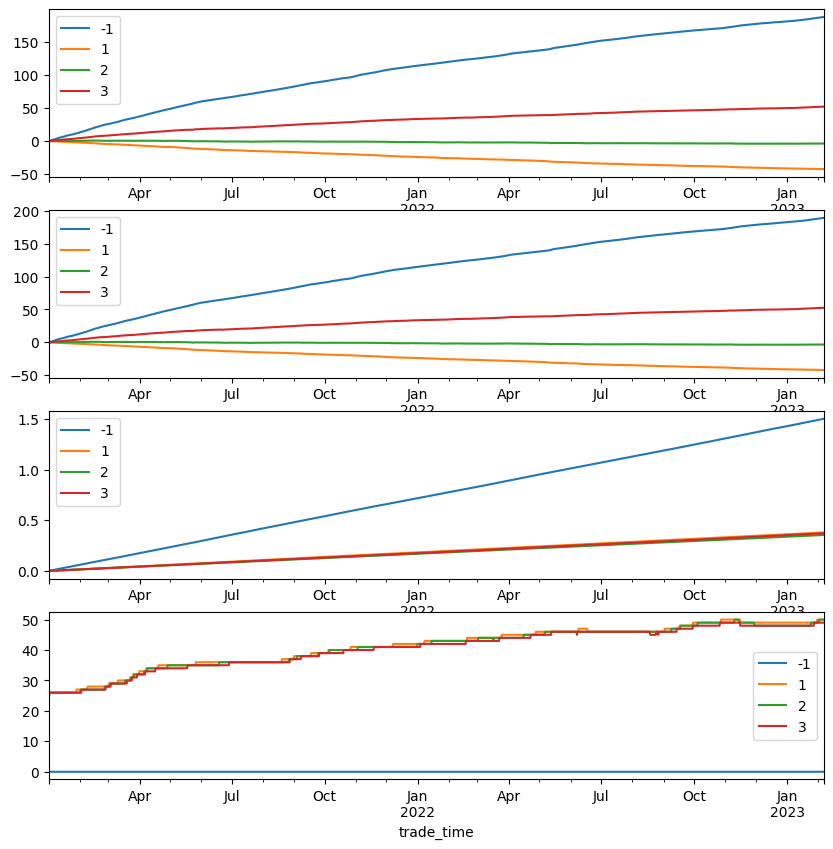

In [36]:
# 4.将数据转为tensor
from torch.utils.data import DataLoader

def z_score(x):
    mean = np.mean(x)
    std = np.std(x)

    # 进行 z-score 标准化
    return (x - mean) / std

batch_size = 8  # 批次大小
device = torch.device("cpu")
x_train_tensor = torch.from_numpy(x_train).to(torch.float32).to(device)
y_train_tensor = torch.from_numpy(y_train).to(torch.float32).to(device)
x_test_tensor = torch.from_numpy(x_test).to(torch.float32).to(device)
y_test_tensor = torch.from_numpy(y_test).to(torch.float32).to(device)

# 5.形成训练数据集
train_data = TensorDataset(x_train_tensor, y_train_tensor)
test_data = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size, False)

test_loader = DataLoader(test_data, batch_size, False)

combo_factor = pd.DataFrame(index_train, columns=['trade_time', 'instrument'])
combo_factor['factor_value'] = y_train_tensor
combo_factor = combo_factor.sort_values(by=['trade_time', 'instrument'])
print(combo_factor)
# cnt = combo_factor.groupby('trade_time')['instrument'].count()
# print(cnt[cnt > 100])
# print(factor_with_label[factor_with_label['trade_time']=='2023-02-10 07:00:00'])
# combo_factor

result = backtest(combo_factor, 3)
sharpe = cal_sharpe(result[result['grp']==-1]['cumret'])
print(sharpe)
draw(result)

In [85]:
x_train[:1024, ::].shape

(1024, 1, 8)

In [40]:
hidden_dim = 16  # 隐层大小
output_dim = 1  # 由于是回归任务，最终输出层大小为1
num_layers = 4  # LSTM的层数

def pearsonr(x, y, dim=0):
    centered_x = x - x.mean(dim=dim, keepdim=True)
    centered_y = y - y.mean(dim=dim, keepdim=True)

    covariance = (centered_x * centered_y).sum(dim=dim, keepdim=True)

    bessel_corrected_covariance = covariance / (x.shape[dim] - 1)

    x_std = x.std(dim=dim, keepdim=True)
    y_std = y.std(dim=dim, keepdim=True)

    corr = bessel_corrected_covariance / (x_std * y_std)

    return corr

class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim  # 隐层大小
        self.num_layers = num_layers  # LSTM层数
        # input_dim为特征维度，就是每个时间点对应的特征数量，这里为14
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        output, h_n = self.gru(x)
        
        # print(output.shape) #torch.Size([16, 1, 64]) batch_size,timestep,hidden_dim
        # print(h_n.shape) torch.Size([3, 16, 64]) num_layers,batch_size,hidden_dim
        # print(c_n.shape) torch.Size([3, 16, 64]) num_layers,batch_size,hidden_dim
        batch_size, timestep, hidden_dim = output.shape

        # 将output变成 batch_size * timestep, hidden_dim
        output = output.reshape(-1, hidden_dim)
        output = self.bn(output)
        output = self.fc(output)  # 形状为batch_size * timestep, output
        output = output.reshape(timestep, batch_size, -1)
        return self.sigmoid(output[-1])  # 返回最后一个时间片的输出

model = GRU(input_dim, hidden_dim, num_layers, output_dim)  # 定义LSTM网络

# loss_function = nn.MSELoss()  # 定义损失函数
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        self.mse_loss = nn.MSELoss()   # 计算每个样本的 MSE
        self.sm = nn.Softmax()
        # self.sc = SpearmanCorrCoef()

    def forward(self, pred, actual):
        loss = self.mse_loss(pred, actual)  # 计算每个样本的平均 MSE
        # loss = (torch.sign(pred * actual) * torch.abs(actual)).mean() * (-1)
        # combined = torch.cat((pred, actual), dim=1)
        # test = torch.cat((torch.ones(actual.shape), actual), dim=1)
        # print(test.reshape(test.shape[::-1]).corrcoef())
        # # print(combined)
        # # combined = torch.softmax(combined, dim=1)
        # corr = combined.reshape(combined.shape[::-1]).corrcoef()
        # # print(corr)
        # # metric = SpearmanCorrCoef()(pred, actual)
        
        # # print(metric)
        # # # print(corr_each)
        # # # print(corr_each)
        # # print(corr)
        # corr_good = -(corr.sum(dim=1)[-1] - 1)
        # print(combined)
        # print(corr_good)
        # corr_bad = (corr[:corr.shape[0]-1, :corr.shape[0]-1].sum(dim=1)[-1] - 1)
        # print(corr_good, corr_bad)
        # loss = corr_good + 0.005 * corr_bad
        # loss = mse + 0.005 * corr_bad
        # output = pearsonr(pred, actual)
        # print(pearsonr(torch.ones(actual.shape), actual))
        # print(output)
        # loss = mse
        return loss  # 最后求平均
    
loss_function = Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # 定义优化器
epochs = 1000
best_loss = 1e10

for epoch in range(epochs):
    model.train()
    running_loss = 0
    train_bar = tqdm(train_loader)  # 形成进度条
    for idx, data in enumerate(train_bar):
        x, y = data  # 解包迭代器中的X和Y
        optimizer.zero_grad()
        y_train_pred: torch.Tensor = model(x)
        # print(y, y_train_pred)
        loss = loss_function(y_train_pred, y.reshape(-1, 1))
        print(loss)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                 epochs,
                                                                 running_loss / (idx + 1))
        break
        
    # if running_loss / len(train_bar) < best_loss * 0.99:
    #     best_loss = running_loss / len(train_bar)
    # else:
    #     break

train epoch[1/1000] loss:0.646:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.6465, grad_fn=<MseLossBackward0>)


train epoch[2/1000] loss:0.642:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.6416, grad_fn=<MseLossBackward0>)


train epoch[3/1000] loss:0.638:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.6385, grad_fn=<MseLossBackward0>)


train epoch[4/1000] loss:0.636:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.6364, grad_fn=<MseLossBackward0>)


train epoch[5/1000] loss:0.635:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.6347, grad_fn=<MseLossBackward0>)


train epoch[6/1000] loss:0.633:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.6331, grad_fn=<MseLossBackward0>)


train epoch[7/1000] loss:0.631:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.6315, grad_fn=<MseLossBackward0>)


train epoch[8/1000] loss:0.630:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.6296, grad_fn=<MseLossBackward0>)


train epoch[9/1000] loss:0.628:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.6276, grad_fn=<MseLossBackward0>)


train epoch[10/1000] loss:0.625:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.6253, grad_fn=<MseLossBackward0>)


train epoch[11/1000] loss:0.623:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.6230, grad_fn=<MseLossBackward0>)


train epoch[12/1000] loss:0.621:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.6207, grad_fn=<MseLossBackward0>)


train epoch[13/1000] loss:0.618:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.6184, grad_fn=<MseLossBackward0>)


train epoch[14/1000] loss:0.616:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.6164, grad_fn=<MseLossBackward0>)


train epoch[15/1000] loss:0.614:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.6144, grad_fn=<MseLossBackward0>)


train epoch[16/1000] loss:0.613:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.6125, grad_fn=<MseLossBackward0>)


train epoch[17/1000] loss:0.610:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.6105, grad_fn=<MseLossBackward0>)


train epoch[18/1000] loss:0.608:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.6082, grad_fn=<MseLossBackward0>)


train epoch[19/1000] loss:0.606:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.6059, grad_fn=<MseLossBackward0>)


train epoch[20/1000] loss:0.604:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.6035, grad_fn=<MseLossBackward0>)


train epoch[21/1000] loss:0.601:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.6012, grad_fn=<MseLossBackward0>)


train epoch[22/1000] loss:0.599:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5991, grad_fn=<MseLossBackward0>)


train epoch[23/1000] loss:0.597:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5971, grad_fn=<MseLossBackward0>)


train epoch[24/1000] loss:0.595:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5952, grad_fn=<MseLossBackward0>)


train epoch[25/1000] loss:0.593:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5931, grad_fn=<MseLossBackward0>)


train epoch[26/1000] loss:0.591:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5911, grad_fn=<MseLossBackward0>)


train epoch[27/1000] loss:0.589:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5891, grad_fn=<MseLossBackward0>)


train epoch[28/1000] loss:0.587:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5873, grad_fn=<MseLossBackward0>)


train epoch[29/1000] loss:0.586:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5856, grad_fn=<MseLossBackward0>)


train epoch[30/1000] loss:0.584:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5841, grad_fn=<MseLossBackward0>)


train epoch[31/1000] loss:0.582:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5825, grad_fn=<MseLossBackward0>)


train epoch[32/1000] loss:0.581:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5809, grad_fn=<MseLossBackward0>)


train epoch[33/1000] loss:0.579:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5794, grad_fn=<MseLossBackward0>)


train epoch[34/1000] loss:0.578:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5780, grad_fn=<MseLossBackward0>)


train epoch[35/1000] loss:0.577:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5767, grad_fn=<MseLossBackward0>)


train epoch[36/1000] loss:0.576:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5755, grad_fn=<MseLossBackward0>)


train epoch[37/1000] loss:0.574:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5743, grad_fn=<MseLossBackward0>)


train epoch[38/1000] loss:0.573:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5731, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.5720, grad_fn=<MseLossBackward0>)


train epoch[40/1000] loss:0.571:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5709, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.5699, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.5688, grad_fn=<MseLossBackward0>)


train epoch[43/1000] loss:0.568:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5678, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.5668, grad_fn=<MseLossBackward0>)


train epoch[45/1000] loss:0.566:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5658, grad_fn=<MseLossBackward0>)


train epoch[46/1000] loss:0.565:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5649, grad_fn=<MseLossBackward0>)


train epoch[47/1000] loss:0.564:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5639, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.5630, grad_fn=<MseLossBackward0>)


train epoch[49/1000] loss:0.562:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5620, grad_fn=<MseLossBackward0>)


train epoch[50/1000] loss:0.561:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5610, grad_fn=<MseLossBackward0>)


train epoch[51/1000] loss:0.560:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5600, grad_fn=<MseLossBackward0>)


train epoch[52/1000] loss:0.559:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5589, grad_fn=<MseLossBackward0>)


train epoch[53/1000] loss:0.558:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5579, grad_fn=<MseLossBackward0>)


train epoch[54/1000] loss:0.557:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5567, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.5556, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.5544, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.5531, grad_fn=<MseLossBackward0>)


train epoch[58/1000] loss:0.552:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5518, grad_fn=<MseLossBackward0>)


train epoch[59/1000] loss:0.550:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5505, grad_fn=<MseLossBackward0>)


train epoch[60/1000] loss:0.549:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5491, grad_fn=<MseLossBackward0>)


train epoch[61/1000] loss:0.548:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.5476, grad_fn=<MseLossBackward0>)



train epoch[62/1000] loss:0.546:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.5461, grad_fn=<MseLossBackward0>)



  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.5446, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.5430, grad_fn=<MseLossBackward0>)


train epoch[65/1000] loss:0.541:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5414, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.5398, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.5383, grad_fn=<MseLossBackward0>)


train epoch[68/1000] loss:0.537:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5367, grad_fn=<MseLossBackward0>)


train epoch[69/1000] loss:0.535:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5351, grad_fn=<MseLossBackward0>)


train epoch[70/1000] loss:0.533:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5335, grad_fn=<MseLossBackward0>)


train epoch[71/1000] loss:0.532:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5319, grad_fn=<MseLossBackward0>)


train epoch[72/1000] loss:0.530:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5303, grad_fn=<MseLossBackward0>)


train epoch[73/1000] loss:0.529:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5287, grad_fn=<MseLossBackward0>)


train epoch[74/1000] loss:0.527:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5271, grad_fn=<MseLossBackward0>)


train epoch[75/1000] loss:0.525:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5254, grad_fn=<MseLossBackward0>)


train epoch[76/1000] loss:0.524:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5237, grad_fn=<MseLossBackward0>)


train epoch[77/1000] loss:0.522:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5220, grad_fn=<MseLossBackward0>)


train epoch[78/1000] loss:0.520:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5202, grad_fn=<MseLossBackward0>)


train epoch[79/1000] loss:0.518:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5183, grad_fn=<MseLossBackward0>)


train epoch[80/1000] loss:0.516:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5165, grad_fn=<MseLossBackward0>)


train epoch[81/1000] loss:0.515:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5146, grad_fn=<MseLossBackward0>)


train epoch[82/1000] loss:0.513:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.5126, grad_fn=<MseLossBackward0>)



  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.5106, grad_fn=<MseLossBackward0>)


train epoch[84/1000] loss:0.509:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5087, grad_fn=<MseLossBackward0>)


train epoch[85/1000] loss:0.507:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5066, grad_fn=<MseLossBackward0>)


train epoch[86/1000] loss:0.505:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.5046, grad_fn=<MseLossBackward0>)


train epoch[87/1000] loss:0.503:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.5025, grad_fn=<MseLossBackward0>)



  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.5004, grad_fn=<MseLossBackward0>)


train epoch[89/1000] loss:0.498:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4983, grad_fn=<MseLossBackward0>)


train epoch[90/1000] loss:0.496:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4961, grad_fn=<MseLossBackward0>)


train epoch[91/1000] loss:0.494:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4939, grad_fn=<MseLossBackward0>)


train epoch[92/1000] loss:0.492:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4917, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.4894, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.4871, grad_fn=<MseLossBackward0>)


train epoch[95/1000] loss:0.485:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4847, grad_fn=<MseLossBackward0>)


train epoch[96/1000] loss:0.482:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4823, grad_fn=<MseLossBackward0>)


train epoch[97/1000] loss:0.480:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4799, grad_fn=<MseLossBackward0>)


train epoch[98/1000] loss:0.477:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4775, grad_fn=<MseLossBackward0>)


train epoch[99/1000] loss:0.475:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4750, grad_fn=<MseLossBackward0>)


train epoch[100/1000] loss:0.473:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4726, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.4701, grad_fn=<MseLossBackward0>)


train epoch[102/1000] loss:0.468:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4676, grad_fn=<MseLossBackward0>)


train epoch[103/1000] loss:0.465:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4651, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.4627, grad_fn=<MseLossBackward0>)

train epoch[104/1000] loss:0.463:   0%|          | 0/283483 [00:00<?, ?it/s]


train epoch[105/1000] loss:0.460:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.4602, grad_fn=<MseLossBackward0>)



train epoch[106/1000] loss:0.458:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4578, grad_fn=<MseLossBackward0>)


train epoch[107/1000] loss:0.455:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4554, grad_fn=<MseLossBackward0>)


train epoch[108/1000] loss:0.453:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4531, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.4509, grad_fn=<MseLossBackward0>)


train epoch[110/1000] loss:0.449:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4491, grad_fn=<MseLossBackward0>)


train epoch[111/1000] loss:0.448:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.4480, grad_fn=<MseLossBackward0>)



train epoch[112/1000] loss:0.445:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4455, grad_fn=<MseLossBackward0>)


train epoch[113/1000] loss:0.443:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4433, grad_fn=<MseLossBackward0>)


train epoch[114/1000] loss:0.442:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4422, grad_fn=<MseLossBackward0>)


train epoch[115/1000] loss:0.440:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4395, grad_fn=<MseLossBackward0>)


train epoch[116/1000] loss:0.439:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4386, grad_fn=<MseLossBackward0>)


train epoch[117/1000] loss:0.436:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4362, grad_fn=<MseLossBackward0>)


train epoch[118/1000] loss:0.435:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4351, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.4330, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.4316, grad_fn=<MseLossBackward0>)


train epoch[121/1000] loss:0.430:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.4297, grad_fn=<MseLossBackward0>)



train epoch[122/1000] loss:0.428:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4281, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.4264, grad_fn=<MseLossBackward0>)


train epoch[124/1000] loss:0.425:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4247, grad_fn=<MseLossBackward0>)


train epoch[125/1000] loss:0.423:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4230, grad_fn=<MseLossBackward0>)


train epoch[126/1000] loss:0.421:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4212, grad_fn=<MseLossBackward0>)


train epoch[127/1000] loss:0.420:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4196, grad_fn=<MseLossBackward0>)


train epoch[128/1000] loss:0.418:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4177, grad_fn=<MseLossBackward0>)


train epoch[129/1000] loss:0.416:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4161, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.4142, grad_fn=<MseLossBackward0>)


train epoch[131/1000] loss:0.413:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4125, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.4107, grad_fn=<MseLossBackward0>)


train epoch[133/1000] loss:0.409:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4090, grad_fn=<MseLossBackward0>)


train epoch[134/1000] loss:0.407:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4072, grad_fn=<MseLossBackward0>)


train epoch[135/1000] loss:0.405:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4055, grad_fn=<MseLossBackward0>)


train epoch[136/1000] loss:0.404:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4037, grad_fn=<MseLossBackward0>)


train epoch[137/1000] loss:0.402:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4020, grad_fn=<MseLossBackward0>)


train epoch[138/1000] loss:0.400:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.4002, grad_fn=<MseLossBackward0>)


train epoch[139/1000] loss:0.398:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3985, grad_fn=<MseLossBackward0>)


train epoch[140/1000] loss:0.397:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3968, grad_fn=<MseLossBackward0>)


train epoch[141/1000] loss:0.395:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3950, grad_fn=<MseLossBackward0>)


train epoch[142/1000] loss:0.393:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3934, grad_fn=<MseLossBackward0>)


train epoch[143/1000] loss:0.392:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3917, grad_fn=<MseLossBackward0>)


train epoch[144/1000] loss:0.390:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3900, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.3883, grad_fn=<MseLossBackward0>)


train epoch[146/1000] loss:0.387:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3867, grad_fn=<MseLossBackward0>)


train epoch[147/1000] loss:0.385:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3850, grad_fn=<MseLossBackward0>)


train epoch[148/1000] loss:0.383:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.3833, grad_fn=<MseLossBackward0>)



train epoch[149/1000] loss:0.382:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3817, grad_fn=<MseLossBackward0>)


train epoch[150/1000] loss:0.380:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3800, grad_fn=<MseLossBackward0>)


train epoch[151/1000] loss:0.378:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3784, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.3768, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.3752, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.3735, grad_fn=<MseLossBackward0>)


train epoch[155/1000] loss:0.372:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3719, grad_fn=<MseLossBackward0>)


train epoch[156/1000] loss:0.370:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3703, grad_fn=<MseLossBackward0>)


train epoch[157/1000] loss:0.369:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3688, grad_fn=<MseLossBackward0>)


train epoch[158/1000] loss:0.367:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3672, grad_fn=<MseLossBackward0>)


train epoch[159/1000] loss:0.366:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.3656, grad_fn=<MseLossBackward0>)



train epoch[160/1000] loss:0.364:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3640, grad_fn=<MseLossBackward0>)


train epoch[161/1000] loss:0.362:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3625, grad_fn=<MseLossBackward0>)


train epoch[162/1000] loss:0.361:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3609, grad_fn=<MseLossBackward0>)


train epoch[163/1000] loss:0.359:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3594, grad_fn=<MseLossBackward0>)


train epoch[164/1000] loss:0.358:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.3579, grad_fn=<MseLossBackward0>)



  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.3564, grad_fn=<MseLossBackward0>)


train epoch[166/1000] loss:0.355:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3549, grad_fn=<MseLossBackward0>)


train epoch[167/1000] loss:0.353:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3534, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.3519, grad_fn=<MseLossBackward0>)


train epoch[169/1000] loss:0.350:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3505, grad_fn=<MseLossBackward0>)


train epoch[170/1000] loss:0.349:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.3490, grad_fn=<MseLossBackward0>)



train epoch[171/1000] loss:0.348:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3476, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.3461, grad_fn=<MseLossBackward0>)


train epoch[173/1000] loss:0.345:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3447, grad_fn=<MseLossBackward0>)


train epoch[174/1000] loss:0.343:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3433, grad_fn=<MseLossBackward0>)


train epoch[175/1000] loss:0.342:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.3419, grad_fn=<MseLossBackward0>)



train epoch[176/1000] loss:0.341:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3405, grad_fn=<MseLossBackward0>)


train epoch[177/1000] loss:0.339:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3392, grad_fn=<MseLossBackward0>)


train epoch[178/1000] loss:0.338:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.3378, grad_fn=<MseLossBackward0>)



train epoch[179/1000] loss:0.336:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3365, grad_fn=<MseLossBackward0>)


train epoch[180/1000] loss:0.335:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3351, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.3338, grad_fn=<MseLossBackward0>)


train epoch[182/1000] loss:0.333:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3325, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.3312, grad_fn=<MseLossBackward0>)


train epoch[184/1000] loss:0.330:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3299, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.3287, grad_fn=<MseLossBackward0>)


train epoch[186/1000] loss:0.327:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3274, grad_fn=<MseLossBackward0>)


train epoch[187/1000] loss:0.326:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3262, grad_fn=<MseLossBackward0>)


train epoch[188/1000] loss:0.325:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3249, grad_fn=<MseLossBackward0>)


train epoch[189/1000] loss:0.324:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3237, grad_fn=<MseLossBackward0>)


train epoch[190/1000] loss:0.322:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3225, grad_fn=<MseLossBackward0>)


train epoch[191/1000] loss:0.321:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3213, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.3201, grad_fn=<MseLossBackward0>)


train epoch[193/1000] loss:0.319:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3190, grad_fn=<MseLossBackward0>)


train epoch[194/1000] loss:0.318:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3178, grad_fn=<MseLossBackward0>)


train epoch[195/1000] loss:0.317:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3167, grad_fn=<MseLossBackward0>)


train epoch[196/1000] loss:0.316:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3155, grad_fn=<MseLossBackward0>)


train epoch[197/1000] loss:0.314:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3144, grad_fn=<MseLossBackward0>)


train epoch[198/1000] loss:0.313:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3133, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.3122, grad_fn=<MseLossBackward0>)


train epoch[200/1000] loss:0.311:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3111, grad_fn=<MseLossBackward0>)


train epoch[201/1000] loss:0.310:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3100, grad_fn=<MseLossBackward0>)


train epoch[202/1000] loss:0.309:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3090, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.3079, grad_fn=<MseLossBackward0>)


train epoch[204/1000] loss:0.307:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3069, grad_fn=<MseLossBackward0>)


train epoch[205/1000] loss:0.306:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3059, grad_fn=<MseLossBackward0>)


train epoch[206/1000] loss:0.305:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3049, grad_fn=<MseLossBackward0>)


train epoch[207/1000] loss:0.304:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3039, grad_fn=<MseLossBackward0>)


train epoch[208/1000] loss:0.303:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3029, grad_fn=<MseLossBackward0>)


train epoch[209/1000] loss:0.302:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3019, grad_fn=<MseLossBackward0>)


train epoch[210/1000] loss:0.301:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3009, grad_fn=<MseLossBackward0>)


train epoch[211/1000] loss:0.300:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.3000, grad_fn=<MseLossBackward0>)


train epoch[212/1000] loss:0.299:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2990, grad_fn=<MseLossBackward0>)


train epoch[213/1000] loss:0.298:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2981, grad_fn=<MseLossBackward0>)


train epoch[214/1000] loss:0.297:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2972, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2963, grad_fn=<MseLossBackward0>)

train epoch[215/1000] loss:0.296:   0%|          | 0/283483 [00:00<?, ?it/s]


train epoch[216/1000] loss:0.295:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2954, grad_fn=<MseLossBackward0>)


train epoch[217/1000] loss:0.294:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2945, grad_fn=<MseLossBackward0>)


train epoch[218/1000] loss:0.294:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2936, grad_fn=<MseLossBackward0>)


train epoch[219/1000] loss:0.293:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2928, grad_fn=<MseLossBackward0>)


train epoch[220/1000] loss:0.292:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2919, grad_fn=<MseLossBackward0>)


train epoch[221/1000] loss:0.291:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2911, grad_fn=<MseLossBackward0>)


train epoch[222/1000] loss:0.290:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2902, grad_fn=<MseLossBackward0>)


train epoch[223/1000] loss:0.289:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2894, grad_fn=<MseLossBackward0>)


train epoch[224/1000] loss:0.289:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2886, grad_fn=<MseLossBackward0>)



  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2878, grad_fn=<MseLossBackward0>)


train epoch[226/1000] loss:0.287:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2870, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2862, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2854, grad_fn=<MseLossBackward0>)


train epoch[229/1000] loss:0.285:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2847, grad_fn=<MseLossBackward0>)



train epoch[230/1000] loss:0.284:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2839, grad_fn=<MseLossBackward0>)


train epoch[231/1000] loss:0.283:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2832, grad_fn=<MseLossBackward0>)


train epoch[232/1000] loss:0.282:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2824, grad_fn=<MseLossBackward0>)


train epoch[233/1000] loss:0.282:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2817, grad_fn=<MseLossBackward0>)


train epoch[234/1000] loss:0.281:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2810, grad_fn=<MseLossBackward0>)



train epoch[235/1000] loss:0.280:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2803, grad_fn=<MseLossBackward0>)


train epoch[236/1000] loss:0.280:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2796, grad_fn=<MseLossBackward0>)


train epoch[237/1000] loss:0.279:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2789, grad_fn=<MseLossBackward0>)


train epoch[238/1000] loss:0.278:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2782, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2775, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2768, grad_fn=<MseLossBackward0>)


train epoch[241/1000] loss:0.276:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2762, grad_fn=<MseLossBackward0>)


train epoch[242/1000] loss:0.276:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2755, grad_fn=<MseLossBackward0>)



train epoch[243/1000] loss:0.275:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2749, grad_fn=<MseLossBackward0>)


train epoch[244/1000] loss:0.274:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2743, grad_fn=<MseLossBackward0>)


train epoch[245/1000] loss:0.274:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2736, grad_fn=<MseLossBackward0>)


train epoch[246/1000] loss:0.273:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2730, grad_fn=<MseLossBackward0>)


train epoch[247/1000] loss:0.272:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2724, grad_fn=<MseLossBackward0>)


train epoch[248/1000] loss:0.272:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2718, grad_fn=<MseLossBackward0>)


train epoch[249/1000] loss:0.271:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2712, grad_fn=<MseLossBackward0>)


train epoch[250/1000] loss:0.271:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2706, grad_fn=<MseLossBackward0>)


train epoch[251/1000] loss:0.270:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2701, grad_fn=<MseLossBackward0>)


train epoch[252/1000] loss:0.269:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2695, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2689, grad_fn=<MseLossBackward0>)


train epoch[254/1000] loss:0.268:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2684, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2678, grad_fn=<MseLossBackward0>)


train epoch[256/1000] loss:0.267:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2673, grad_fn=<MseLossBackward0>)


train epoch[257/1000] loss:0.267:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2667, grad_fn=<MseLossBackward0>)


train epoch[258/1000] loss:0.266:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2662, grad_fn=<MseLossBackward0>)


train epoch[259/1000] loss:0.266:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2657, grad_fn=<MseLossBackward0>)


train epoch[260/1000] loss:0.265:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2652, grad_fn=<MseLossBackward0>)


train epoch[261/1000] loss:0.265:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2646, grad_fn=<MseLossBackward0>)


train epoch[262/1000] loss:0.264:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2641, grad_fn=<MseLossBackward0>)


train epoch[263/1000] loss:0.264:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2636, grad_fn=<MseLossBackward0>)


train epoch[264/1000] loss:0.263:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2632, grad_fn=<MseLossBackward0>)


train epoch[265/1000] loss:0.263:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2627, grad_fn=<MseLossBackward0>)


train epoch[266/1000] loss:0.262:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2622, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2617, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2613, grad_fn=<MseLossBackward0>)


train epoch[269/1000] loss:0.261:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2608, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2603, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2599, grad_fn=<MseLossBackward0>)


train epoch[272/1000] loss:0.259:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2594, grad_fn=<MseLossBackward0>)


train epoch[273/1000] loss:0.259:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2590, grad_fn=<MseLossBackward0>)


train epoch[274/1000] loss:0.259:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2586, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2581, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2577, grad_fn=<MseLossBackward0>)


train epoch[277/1000] loss:0.257:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2573, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2569, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2565, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2561, grad_fn=<MseLossBackward0>)


train epoch[281/1000] loss:0.256:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2557, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2553, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2549, grad_fn=<MseLossBackward0>)


train epoch[284/1000] loss:0.255:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2545, grad_fn=<MseLossBackward0>)


train epoch[285/1000] loss:0.254:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2541, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2538, grad_fn=<MseLossBackward0>)


train epoch[287/1000] loss:0.253:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2534, grad_fn=<MseLossBackward0>)


train epoch[288/1000] loss:0.253:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2530, grad_fn=<MseLossBackward0>)


train epoch[289/1000] loss:0.253:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2527, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2523, grad_fn=<MseLossBackward0>)


train epoch[291/1000] loss:0.252:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2520, grad_fn=<MseLossBackward0>)



train epoch[292/1000] loss:0.252:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2516, grad_fn=<MseLossBackward0>)


train epoch[293/1000] loss:0.251:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2513, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2509, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2506, grad_fn=<MseLossBackward0>)


train epoch[296/1000] loss:0.250:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2503, grad_fn=<MseLossBackward0>)


train epoch[297/1000] loss:0.250:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2499, grad_fn=<MseLossBackward0>)



  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2496, grad_fn=<MseLossBackward0>)


train epoch[299/1000] loss:0.249:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2493, grad_fn=<MseLossBackward0>)


train epoch[300/1000] loss:0.249:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2490, grad_fn=<MseLossBackward0>)


train epoch[301/1000] loss:0.249:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2487, grad_fn=<MseLossBackward0>)


train epoch[302/1000] loss:0.248:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2484, grad_fn=<MseLossBackward0>)



train epoch[303/1000] loss:0.248:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2480, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2477, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2474, grad_fn=<MseLossBackward0>)


train epoch[306/1000] loss:0.247:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2472, grad_fn=<MseLossBackward0>)


train epoch[307/1000] loss:0.247:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2469, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2466, grad_fn=<MseLossBackward0>)


train epoch[309/1000] loss:0.246:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2463, grad_fn=<MseLossBackward0>)


train epoch[310/1000] loss:0.246:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2460, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2457, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2455, grad_fn=<MseLossBackward0>)


train epoch[313/1000] loss:0.245:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2452, grad_fn=<MseLossBackward0>)



  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2449, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2446, grad_fn=<MseLossBackward0>)


train epoch[316/1000] loss:0.244:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2444, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2441, grad_fn=<MseLossBackward0>)


train epoch[318/1000] loss:0.244:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2439, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2436, grad_fn=<MseLossBackward0>)


train epoch[320/1000] loss:0.243:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2434, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2431, grad_fn=<MseLossBackward0>)


train epoch[322/1000] loss:0.243:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2429, grad_fn=<MseLossBackward0>)



train epoch[323/1000] loss:0.243:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2426, grad_fn=<MseLossBackward0>)


train epoch[324/1000] loss:0.242:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2424, grad_fn=<MseLossBackward0>)


train epoch[325/1000] loss:0.242:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2422, grad_fn=<MseLossBackward0>)


train epoch[326/1000] loss:0.242:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2419, grad_fn=<MseLossBackward0>)


train epoch[327/1000] loss:0.242:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2417, grad_fn=<MseLossBackward0>)


train epoch[328/1000] loss:0.241:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2415, grad_fn=<MseLossBackward0>)


train epoch[329/1000] loss:0.241:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2412, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2410, grad_fn=<MseLossBackward0>)


train epoch[331/1000] loss:0.241:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2408, grad_fn=<MseLossBackward0>)


train epoch[332/1000] loss:0.241:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2406, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2403, grad_fn=<MseLossBackward0>)

train epoch[333/1000] loss:0.240:   0%|          | 0/283483 [00:00<?, ?it/s]


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2401, grad_fn=<MseLossBackward0>)


train epoch[335/1000] loss:0.240:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2399, grad_fn=<MseLossBackward0>)


train epoch[336/1000] loss:0.240:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2397, grad_fn=<MseLossBackward0>)


train epoch[337/1000] loss:0.239:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2395, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2393, grad_fn=<MseLossBackward0>)


train epoch[339/1000] loss:0.239:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2391, grad_fn=<MseLossBackward0>)


train epoch[340/1000] loss:0.239:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2389, grad_fn=<MseLossBackward0>)


train epoch[341/1000] loss:0.239:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2387, grad_fn=<MseLossBackward0>)


train epoch[342/1000] loss:0.238:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2385, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2383, grad_fn=<MseLossBackward0>)


train epoch[344/1000] loss:0.238:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2381, grad_fn=<MseLossBackward0>)


train epoch[345/1000] loss:0.238:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2379, grad_fn=<MseLossBackward0>)



train epoch[346/1000] loss:0.238:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2377, grad_fn=<MseLossBackward0>)


train epoch[347/1000] loss:0.238:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2375, grad_fn=<MseLossBackward0>)


train epoch[348/1000] loss:0.237:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2373, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2372, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2370, grad_fn=<MseLossBackward0>)


train epoch[351/1000] loss:0.237:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2368, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2366, grad_fn=<MseLossBackward0>)


train epoch[353/1000] loss:0.236:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2365, grad_fn=<MseLossBackward0>)


train epoch[354/1000] loss:0.236:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2363, grad_fn=<MseLossBackward0>)


train epoch[355/1000] loss:0.236:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2361, grad_fn=<MseLossBackward0>)



train epoch[356/1000] loss:0.236:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2359, grad_fn=<MseLossBackward0>)


train epoch[357/1000] loss:0.236:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2358, grad_fn=<MseLossBackward0>)


train epoch[358/1000] loss:0.236:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2356, grad_fn=<MseLossBackward0>)


train epoch[359/1000] loss:0.235:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2354, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2353, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2351, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2349, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2348, grad_fn=<MseLossBackward0>)


train epoch[364/1000] loss:0.235:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2346, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2345, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2343, grad_fn=<MseLossBackward0>)


train epoch[367/1000] loss:0.234:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2342, grad_fn=<MseLossBackward0>)



train epoch[368/1000] loss:0.234:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2340, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2339, grad_fn=<MseLossBackward0>)


train epoch[370/1000] loss:0.234:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2337, grad_fn=<MseLossBackward0>)


train epoch[371/1000] loss:0.234:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2336, grad_fn=<MseLossBackward0>)


train epoch[372/1000] loss:0.233:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2334, grad_fn=<MseLossBackward0>)


train epoch[373/1000] loss:0.233:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2333, grad_fn=<MseLossBackward0>)


train epoch[374/1000] loss:0.233:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2331, grad_fn=<MseLossBackward0>)


train epoch[375/1000] loss:0.233:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2330, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2329, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2327, grad_fn=<MseLossBackward0>)


train epoch[378/1000] loss:0.233:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2326, grad_fn=<MseLossBackward0>)


train epoch[379/1000] loss:0.232:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2325, grad_fn=<MseLossBackward0>)


train epoch[380/1000] loss:0.232:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2323, grad_fn=<MseLossBackward0>)


train epoch[381/1000] loss:0.232:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2322, grad_fn=<MseLossBackward0>)


train epoch[382/1000] loss:0.232:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2321, grad_fn=<MseLossBackward0>)


train epoch[383/1000] loss:0.232:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2319, grad_fn=<MseLossBackward0>)


train epoch[384/1000] loss:0.232:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2318, grad_fn=<MseLossBackward0>)


train epoch[385/1000] loss:0.232:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2317, grad_fn=<MseLossBackward0>)


train epoch[386/1000] loss:0.232:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2315, grad_fn=<MseLossBackward0>)



train epoch[387/1000] loss:0.231:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2314, grad_fn=<MseLossBackward0>)


train epoch[388/1000] loss:0.231:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2313, grad_fn=<MseLossBackward0>)


train epoch[389/1000] loss:0.231:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2312, grad_fn=<MseLossBackward0>)


train epoch[390/1000] loss:0.231:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2310, grad_fn=<MseLossBackward0>)


train epoch[391/1000] loss:0.231:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2309, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2308, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2307, grad_fn=<MseLossBackward0>)


train epoch[394/1000] loss:0.231:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2306, grad_fn=<MseLossBackward0>)


train epoch[395/1000] loss:0.230:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2304, grad_fn=<MseLossBackward0>)


train epoch[396/1000] loss:0.230:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2303, grad_fn=<MseLossBackward0>)


train epoch[397/1000] loss:0.230:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2302, grad_fn=<MseLossBackward0>)


train epoch[398/1000] loss:0.230:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2301, grad_fn=<MseLossBackward0>)


train epoch[399/1000] loss:0.230:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2300, grad_fn=<MseLossBackward0>)


train epoch[400/1000] loss:0.230:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2299, grad_fn=<MseLossBackward0>)


train epoch[401/1000] loss:0.230:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2298, grad_fn=<MseLossBackward0>)


train epoch[402/1000] loss:0.230:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2297, grad_fn=<MseLossBackward0>)


train epoch[403/1000] loss:0.230:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2295, grad_fn=<MseLossBackward0>)


train epoch[404/1000] loss:0.229:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2294, grad_fn=<MseLossBackward0>)


train epoch[405/1000] loss:0.229:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2293, grad_fn=<MseLossBackward0>)


train epoch[406/1000] loss:0.229:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2292, grad_fn=<MseLossBackward0>)


train epoch[407/1000] loss:0.229:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2291, grad_fn=<MseLossBackward0>)


train epoch[408/1000] loss:0.229:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2290, grad_fn=<MseLossBackward0>)


train epoch[409/1000] loss:0.229:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2289, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2288, grad_fn=<MseLossBackward0>)


train epoch[411/1000] loss:0.229:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2287, grad_fn=<MseLossBackward0>)


train epoch[412/1000] loss:0.229:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2286, grad_fn=<MseLossBackward0>)


train epoch[413/1000] loss:0.229:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2285, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2284, grad_fn=<MseLossBackward0>)


train epoch[415/1000] loss:0.228:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2283, grad_fn=<MseLossBackward0>)


train epoch[416/1000] loss:0.228:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2282, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2281, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2280, grad_fn=<MseLossBackward0>)


train epoch[419/1000] loss:0.228:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2279, grad_fn=<MseLossBackward0>)


train epoch[420/1000] loss:0.228:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2278, grad_fn=<MseLossBackward0>)


train epoch[421/1000] loss:0.228:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2278, grad_fn=<MseLossBackward0>)


train epoch[422/1000] loss:0.228:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2277, grad_fn=<MseLossBackward0>)


train epoch[423/1000] loss:0.228:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2276, grad_fn=<MseLossBackward0>)


train epoch[424/1000] loss:0.227:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2275, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2274, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2273, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2272, grad_fn=<MseLossBackward0>)


train epoch[428/1000] loss:0.227:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2271, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2270, grad_fn=<MseLossBackward0>)


train epoch[430/1000] loss:0.227:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2270, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2269, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2268, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2267, grad_fn=<MseLossBackward0>)


train epoch[434/1000] loss:0.227:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2266, grad_fn=<MseLossBackward0>)


train epoch[435/1000] loss:0.227:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2265, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2265, grad_fn=<MseLossBackward0>)


train epoch[437/1000] loss:0.226:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2264, grad_fn=<MseLossBackward0>)


train epoch[438/1000] loss:0.226:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2263, grad_fn=<MseLossBackward0>)


train epoch[439/1000] loss:0.226:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2262, grad_fn=<MseLossBackward0>)


train epoch[440/1000] loss:0.226:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2261, grad_fn=<MseLossBackward0>)


train epoch[441/1000] loss:0.226:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2261, grad_fn=<MseLossBackward0>)


train epoch[442/1000] loss:0.226:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2260, grad_fn=<MseLossBackward0>)


train epoch[443/1000] loss:0.226:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2259, grad_fn=<MseLossBackward0>)


train epoch[444/1000] loss:0.226:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2258, grad_fn=<MseLossBackward0>)


train epoch[445/1000] loss:0.226:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2257, grad_fn=<MseLossBackward0>)


train epoch[446/1000] loss:0.226:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2257, grad_fn=<MseLossBackward0>)


train epoch[447/1000] loss:0.226:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2256, grad_fn=<MseLossBackward0>)


train epoch[448/1000] loss:0.226:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2255, grad_fn=<MseLossBackward0>)


train epoch[449/1000] loss:0.225:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2255, grad_fn=<MseLossBackward0>)


train epoch[450/1000] loss:0.225:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2254, grad_fn=<MseLossBackward0>)


train epoch[451/1000] loss:0.225:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2253, grad_fn=<MseLossBackward0>)


train epoch[452/1000] loss:0.225:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2252, grad_fn=<MseLossBackward0>)


train epoch[453/1000] loss:0.225:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2252, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2251, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2250, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2250, grad_fn=<MseLossBackward0>)


train epoch[457/1000] loss:0.225:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2249, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2248, grad_fn=<MseLossBackward0>)


train epoch[459/1000] loss:0.225:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2247, grad_fn=<MseLossBackward0>)


train epoch[460/1000] loss:0.225:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2247, grad_fn=<MseLossBackward0>)


train epoch[461/1000] loss:0.225:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2246, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2245, grad_fn=<MseLossBackward0>)


train epoch[463/1000] loss:0.224:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2245, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2244, grad_fn=<MseLossBackward0>)


train epoch[465/1000] loss:0.224:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2244, grad_fn=<MseLossBackward0>)


train epoch[466/1000] loss:0.224:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2243, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2242, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2242, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2241, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2240, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2240, grad_fn=<MseLossBackward0>)


train epoch[472/1000] loss:0.224:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2239, grad_fn=<MseLossBackward0>)


train epoch[473/1000] loss:0.224:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2239, grad_fn=<MseLossBackward0>)


train epoch[474/1000] loss:0.224:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2238, grad_fn=<MseLossBackward0>)


train epoch[475/1000] loss:0.224:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2237, grad_fn=<MseLossBackward0>)


train epoch[476/1000] loss:0.224:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2237, grad_fn=<MseLossBackward0>)


train epoch[477/1000] loss:0.224:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2236, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2236, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2235, grad_fn=<MseLossBackward0>)


train epoch[480/1000] loss:0.223:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2234, grad_fn=<MseLossBackward0>)


train epoch[481/1000] loss:0.223:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2234, grad_fn=<MseLossBackward0>)


train epoch[482/1000] loss:0.223:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2233, grad_fn=<MseLossBackward0>)


train epoch[483/1000] loss:0.223:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2233, grad_fn=<MseLossBackward0>)


train epoch[484/1000] loss:0.223:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2232, grad_fn=<MseLossBackward0>)


train epoch[485/1000] loss:0.223:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2232, grad_fn=<MseLossBackward0>)


train epoch[486/1000] loss:0.223:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2231, grad_fn=<MseLossBackward0>)


train epoch[487/1000] loss:0.223:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2230, grad_fn=<MseLossBackward0>)


train epoch[488/1000] loss:0.223:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2230, grad_fn=<MseLossBackward0>)


train epoch[489/1000] loss:0.223:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2229, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2229, grad_fn=<MseLossBackward0>)


train epoch[491/1000] loss:0.223:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2228, grad_fn=<MseLossBackward0>)


train epoch[492/1000] loss:0.223:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2228, grad_fn=<MseLossBackward0>)


train epoch[493/1000] loss:0.223:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2227, grad_fn=<MseLossBackward0>)


train epoch[494/1000] loss:0.223:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2227, grad_fn=<MseLossBackward0>)


train epoch[495/1000] loss:0.223:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2226, grad_fn=<MseLossBackward0>)


train epoch[496/1000] loss:0.223:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2226, grad_fn=<MseLossBackward0>)


train epoch[497/1000] loss:0.223:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2225, grad_fn=<MseLossBackward0>)


train epoch[498/1000] loss:0.222:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2225, grad_fn=<MseLossBackward0>)


train epoch[499/1000] loss:0.222:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2224, grad_fn=<MseLossBackward0>)


train epoch[500/1000] loss:0.222:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2224, grad_fn=<MseLossBackward0>)


train epoch[501/1000] loss:0.222:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2223, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2223, grad_fn=<MseLossBackward0>)


train epoch[503/1000] loss:0.222:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2222, grad_fn=<MseLossBackward0>)


train epoch[504/1000] loss:0.222:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2222, grad_fn=<MseLossBackward0>)


train epoch[505/1000] loss:0.222:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2221, grad_fn=<MseLossBackward0>)


train epoch[506/1000] loss:0.222:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2221, grad_fn=<MseLossBackward0>)


train epoch[507/1000] loss:0.222:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2220, grad_fn=<MseLossBackward0>)


train epoch[508/1000] loss:0.222:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2220, grad_fn=<MseLossBackward0>)


train epoch[509/1000] loss:0.222:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2219, grad_fn=<MseLossBackward0>)


train epoch[510/1000] loss:0.222:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2219, grad_fn=<MseLossBackward0>)


train epoch[511/1000] loss:0.222:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2218, grad_fn=<MseLossBackward0>)


train epoch[512/1000] loss:0.222:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2218, grad_fn=<MseLossBackward0>)


train epoch[513/1000] loss:0.222:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2217, grad_fn=<MseLossBackward0>)


train epoch[514/1000] loss:0.222:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2217, grad_fn=<MseLossBackward0>)



train epoch[515/1000] loss:0.222:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2217, grad_fn=<MseLossBackward0>)



train epoch[516/1000] loss:0.222:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2216, grad_fn=<MseLossBackward0>)


train epoch[517/1000] loss:0.222:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2216, grad_fn=<MseLossBackward0>)


train epoch[518/1000] loss:0.222:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2215, grad_fn=<MseLossBackward0>)



train epoch[519/1000] loss:0.221:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2215, grad_fn=<MseLossBackward0>)



train epoch[520/1000] loss:0.221:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2214, grad_fn=<MseLossBackward0>)



train epoch[521/1000] loss:0.221:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2214, grad_fn=<MseLossBackward0>)



train epoch[522/1000] loss:0.221:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2214, grad_fn=<MseLossBackward0>)


train epoch[523/1000] loss:0.221:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2213, grad_fn=<MseLossBackward0>)


train epoch[524/1000] loss:0.221:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2213, grad_fn=<MseLossBackward0>)


train epoch[525/1000] loss:0.221:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2212, grad_fn=<MseLossBackward0>)


train epoch[526/1000] loss:0.221:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2212, grad_fn=<MseLossBackward0>)


train epoch[527/1000] loss:0.221:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2211, grad_fn=<MseLossBackward0>)



  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2211, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2211, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2210, grad_fn=<MseLossBackward0>)


train epoch[531/1000] loss:0.221:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2210, grad_fn=<MseLossBackward0>)


train epoch[532/1000] loss:0.221:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2209, grad_fn=<MseLossBackward0>)


train epoch[533/1000] loss:0.221:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2209, grad_fn=<MseLossBackward0>)


train epoch[534/1000] loss:0.221:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2209, grad_fn=<MseLossBackward0>)



train epoch[535/1000] loss:0.221:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2208, grad_fn=<MseLossBackward0>)


train epoch[536/1000] loss:0.221:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2208, grad_fn=<MseLossBackward0>)


train epoch[537/1000] loss:0.221:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2207, grad_fn=<MseLossBackward0>)


train epoch[538/1000] loss:0.221:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2207, grad_fn=<MseLossBackward0>)


train epoch[539/1000] loss:0.221:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2207, grad_fn=<MseLossBackward0>)


train epoch[540/1000] loss:0.221:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2206, grad_fn=<MseLossBackward0>)


train epoch[541/1000] loss:0.221:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2206, grad_fn=<MseLossBackward0>)


train epoch[542/1000] loss:0.221:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2205, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2205, grad_fn=<MseLossBackward0>)


train epoch[544/1000] loss:0.220:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2205, grad_fn=<MseLossBackward0>)


train epoch[545/1000] loss:0.220:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2204, grad_fn=<MseLossBackward0>)


train epoch[546/1000] loss:0.220:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2204, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2204, grad_fn=<MseLossBackward0>)


train epoch[548/1000] loss:0.220:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2203, grad_fn=<MseLossBackward0>)


train epoch[549/1000] loss:0.220:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2203, grad_fn=<MseLossBackward0>)


train epoch[550/1000] loss:0.220:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2203, grad_fn=<MseLossBackward0>)


train epoch[551/1000] loss:0.220:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2202, grad_fn=<MseLossBackward0>)


train epoch[552/1000] loss:0.220:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2202, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2201, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2201, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2201, grad_fn=<MseLossBackward0>)


train epoch[556/1000] loss:0.220:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2200, grad_fn=<MseLossBackward0>)


train epoch[557/1000] loss:0.220:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2200, grad_fn=<MseLossBackward0>)


train epoch[558/1000] loss:0.220:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2200, grad_fn=<MseLossBackward0>)


train epoch[559/1000] loss:0.220:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2199, grad_fn=<MseLossBackward0>)


train epoch[560/1000] loss:0.220:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2199, grad_fn=<MseLossBackward0>)


train epoch[561/1000] loss:0.220:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2199, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2198, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2198, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2198, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2197, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2197, grad_fn=<MseLossBackward0>)


train epoch[567/1000] loss:0.220:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2197, grad_fn=<MseLossBackward0>)


train epoch[568/1000] loss:0.220:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2196, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2196, grad_fn=<MseLossBackward0>)


train epoch[570/1000] loss:0.220:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2196, grad_fn=<MseLossBackward0>)


train epoch[571/1000] loss:0.220:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2196, grad_fn=<MseLossBackward0>)


train epoch[572/1000] loss:0.220:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2195, grad_fn=<MseLossBackward0>)


train epoch[573/1000] loss:0.219:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2195, grad_fn=<MseLossBackward0>)


train epoch[574/1000] loss:0.219:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2195, grad_fn=<MseLossBackward0>)



train epoch[575/1000] loss:0.219:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2194, grad_fn=<MseLossBackward0>)


train epoch[576/1000] loss:0.219:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2194, grad_fn=<MseLossBackward0>)


train epoch[577/1000] loss:0.219:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2194, grad_fn=<MseLossBackward0>)


train epoch[578/1000] loss:0.219:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2193, grad_fn=<MseLossBackward0>)



  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2193, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2193, grad_fn=<MseLossBackward0>)


train epoch[581/1000] loss:0.219:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2192, grad_fn=<MseLossBackward0>)


train epoch[582/1000] loss:0.219:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2192, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2192, grad_fn=<MseLossBackward0>)


train epoch[584/1000] loss:0.219:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2192, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2191, grad_fn=<MseLossBackward0>)


train epoch[586/1000] loss:0.219:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2191, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2191, grad_fn=<MseLossBackward0>)


train epoch[588/1000] loss:0.219:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2190, grad_fn=<MseLossBackward0>)


train epoch[589/1000] loss:0.219:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2190, grad_fn=<MseLossBackward0>)


train epoch[590/1000] loss:0.219:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2190, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2190, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2189, grad_fn=<MseLossBackward0>)


train epoch[593/1000] loss:0.219:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2189, grad_fn=<MseLossBackward0>)


train epoch[594/1000] loss:0.219:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2189, grad_fn=<MseLossBackward0>)



train epoch[595/1000] loss:0.219:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2189, grad_fn=<MseLossBackward0>)


train epoch[596/1000] loss:0.219:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2188, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2188, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2188, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2187, grad_fn=<MseLossBackward0>)


train epoch[600/1000] loss:0.219:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2187, grad_fn=<MseLossBackward0>)


train epoch[601/1000] loss:0.219:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2187, grad_fn=<MseLossBackward0>)


train epoch[602/1000] loss:0.219:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2187, grad_fn=<MseLossBackward0>)


train epoch[603/1000] loss:0.219:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2186, grad_fn=<MseLossBackward0>)


train epoch[604/1000] loss:0.219:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2186, grad_fn=<MseLossBackward0>)


train epoch[605/1000] loss:0.219:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2186, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2186, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2185, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2185, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2185, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2185, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2184, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2184, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2184, grad_fn=<MseLossBackward0>)


train epoch[614/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2184, grad_fn=<MseLossBackward0>)



train epoch[615/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2183, grad_fn=<MseLossBackward0>)


train epoch[616/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2183, grad_fn=<MseLossBackward0>)



train epoch[617/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2183, grad_fn=<MseLossBackward0>)


train epoch[618/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2183, grad_fn=<MseLossBackward0>)


train epoch[619/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2182, grad_fn=<MseLossBackward0>)


train epoch[620/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2182, grad_fn=<MseLossBackward0>)


train epoch[621/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2182, grad_fn=<MseLossBackward0>)


train epoch[622/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2182, grad_fn=<MseLossBackward0>)


train epoch[623/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2181, grad_fn=<MseLossBackward0>)


train epoch[624/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2181, grad_fn=<MseLossBackward0>)


train epoch[625/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2181, grad_fn=<MseLossBackward0>)


train epoch[626/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2181, grad_fn=<MseLossBackward0>)


train epoch[627/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2181, grad_fn=<MseLossBackward0>)


train epoch[628/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2180, grad_fn=<MseLossBackward0>)


train epoch[629/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2180, grad_fn=<MseLossBackward0>)


train epoch[630/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2180, grad_fn=<MseLossBackward0>)


train epoch[631/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2180, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2179, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2179, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2179, grad_fn=<MseLossBackward0>)


train epoch[635/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2179, grad_fn=<MseLossBackward0>)


train epoch[636/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2179, grad_fn=<MseLossBackward0>)


train epoch[637/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2178, grad_fn=<MseLossBackward0>)


train epoch[638/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2178, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2178, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2178, grad_fn=<MseLossBackward0>)


train epoch[641/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2177, grad_fn=<MseLossBackward0>)


train epoch[642/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2177, grad_fn=<MseLossBackward0>)


train epoch[643/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2177, grad_fn=<MseLossBackward0>)


train epoch[644/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2177, grad_fn=<MseLossBackward0>)


train epoch[645/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2177, grad_fn=<MseLossBackward0>)


train epoch[646/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2176, grad_fn=<MseLossBackward0>)


train epoch[647/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2176, grad_fn=<MseLossBackward0>)


train epoch[648/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2176, grad_fn=<MseLossBackward0>)


train epoch[649/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2176, grad_fn=<MseLossBackward0>)


train epoch[650/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2176, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2175, grad_fn=<MseLossBackward0>)

train epoch[651/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


train epoch[652/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2175, grad_fn=<MseLossBackward0>)


train epoch[653/1000] loss:0.218:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2175, grad_fn=<MseLossBackward0>)



  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2175, grad_fn=<MseLossBackward0>)


train epoch[655/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2175, grad_fn=<MseLossBackward0>)


train epoch[656/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2174, grad_fn=<MseLossBackward0>)


train epoch[657/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2174, grad_fn=<MseLossBackward0>)


train epoch[658/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2174, grad_fn=<MseLossBackward0>)


train epoch[659/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2174, grad_fn=<MseLossBackward0>)



  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2174, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2173, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2173, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2173, grad_fn=<MseLossBackward0>)


train epoch[664/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2173, grad_fn=<MseLossBackward0>)


train epoch[665/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2173, grad_fn=<MseLossBackward0>)


train epoch[666/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2173, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2172, grad_fn=<MseLossBackward0>)


train epoch[668/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2172, grad_fn=<MseLossBackward0>)


train epoch[669/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2172, grad_fn=<MseLossBackward0>)


train epoch[670/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2172, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2172, grad_fn=<MseLossBackward0>)

train epoch[671/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


train epoch[672/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2171, grad_fn=<MseLossBackward0>)


train epoch[673/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2171, grad_fn=<MseLossBackward0>)



train epoch[674/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2171, grad_fn=<MseLossBackward0>)


train epoch[675/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2171, grad_fn=<MseLossBackward0>)


train epoch[676/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2171, grad_fn=<MseLossBackward0>)


train epoch[677/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2171, grad_fn=<MseLossBackward0>)


train epoch[678/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2170, grad_fn=<MseLossBackward0>)


train epoch[679/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2170, grad_fn=<MseLossBackward0>)


train epoch[680/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2170, grad_fn=<MseLossBackward0>)


train epoch[681/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2170, grad_fn=<MseLossBackward0>)


train epoch[682/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2170, grad_fn=<MseLossBackward0>)


train epoch[683/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2170, grad_fn=<MseLossBackward0>)


train epoch[684/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2169, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2169, grad_fn=<MseLossBackward0>)


train epoch[686/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2169, grad_fn=<MseLossBackward0>)


train epoch[687/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2169, grad_fn=<MseLossBackward0>)


train epoch[688/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2169, grad_fn=<MseLossBackward0>)


train epoch[689/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2169, grad_fn=<MseLossBackward0>)


train epoch[690/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2168, grad_fn=<MseLossBackward0>)


train epoch[691/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2168, grad_fn=<MseLossBackward0>)


train epoch[692/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2168, grad_fn=<MseLossBackward0>)


train epoch[693/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2168, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2168, grad_fn=<MseLossBackward0>)

train epoch[694/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


train epoch[695/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2168, grad_fn=<MseLossBackward0>)


train epoch[696/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2167, grad_fn=<MseLossBackward0>)


train epoch[697/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2167, grad_fn=<MseLossBackward0>)



train epoch[698/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2167, grad_fn=<MseLossBackward0>)


train epoch[699/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2167, grad_fn=<MseLossBackward0>)


train epoch[700/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2167, grad_fn=<MseLossBackward0>)



train epoch[701/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2167, grad_fn=<MseLossBackward0>)


train epoch[702/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2166, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2166, grad_fn=<MseLossBackward0>)


train epoch[704/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2166, grad_fn=<MseLossBackward0>)


train epoch[705/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2166, grad_fn=<MseLossBackward0>)


train epoch[706/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2166, grad_fn=<MseLossBackward0>)


train epoch[707/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2166, grad_fn=<MseLossBackward0>)


train epoch[708/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2166, grad_fn=<MseLossBackward0>)


train epoch[709/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2165, grad_fn=<MseLossBackward0>)


train epoch[710/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2165, grad_fn=<MseLossBackward0>)


train epoch[711/1000] loss:0.217:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2165, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2165, grad_fn=<MseLossBackward0>)


train epoch[713/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2165, grad_fn=<MseLossBackward0>)


train epoch[714/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2165, grad_fn=<MseLossBackward0>)


train epoch[715/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2164, grad_fn=<MseLossBackward0>)


train epoch[716/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2164, grad_fn=<MseLossBackward0>)


train epoch[717/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2164, grad_fn=<MseLossBackward0>)


train epoch[718/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2164, grad_fn=<MseLossBackward0>)


train epoch[719/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2164, grad_fn=<MseLossBackward0>)


train epoch[720/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2164, grad_fn=<MseLossBackward0>)


train epoch[721/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2164, grad_fn=<MseLossBackward0>)


train epoch[722/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2163, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2163, grad_fn=<MseLossBackward0>)


train epoch[724/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2163, grad_fn=<MseLossBackward0>)


train epoch[725/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2163, grad_fn=<MseLossBackward0>)


train epoch[726/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2163, grad_fn=<MseLossBackward0>)


train epoch[727/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2163, grad_fn=<MseLossBackward0>)


train epoch[728/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2163, grad_fn=<MseLossBackward0>)


train epoch[729/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2162, grad_fn=<MseLossBackward0>)


train epoch[730/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2162, grad_fn=<MseLossBackward0>)


train epoch[731/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2162, grad_fn=<MseLossBackward0>)


train epoch[732/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2162, grad_fn=<MseLossBackward0>)


train epoch[733/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2162, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2162, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2162, grad_fn=<MseLossBackward0>)


train epoch[736/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2162, grad_fn=<MseLossBackward0>)


train epoch[737/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2161, grad_fn=<MseLossBackward0>)



  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2161, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2161, grad_fn=<MseLossBackward0>)


train epoch[740/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2161, grad_fn=<MseLossBackward0>)



train epoch[741/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2161, grad_fn=<MseLossBackward0>)


train epoch[742/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2161, grad_fn=<MseLossBackward0>)



  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2161, grad_fn=<MseLossBackward0>)


train epoch[744/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2161, grad_fn=<MseLossBackward0>)



train epoch[745/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2160, grad_fn=<MseLossBackward0>)


train epoch[746/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2160, grad_fn=<MseLossBackward0>)


train epoch[747/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2160, grad_fn=<MseLossBackward0>)


train epoch[748/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2160, grad_fn=<MseLossBackward0>)


train epoch[749/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2160, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2160, grad_fn=<MseLossBackward0>)


train epoch[751/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2160, grad_fn=<MseLossBackward0>)


train epoch[752/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2160, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2159, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2159, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2159, grad_fn=<MseLossBackward0>)


train epoch[756/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2159, grad_fn=<MseLossBackward0>)


train epoch[757/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2159, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2159, grad_fn=<MseLossBackward0>)


train epoch[759/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2159, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2159, grad_fn=<MseLossBackward0>)


train epoch[761/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2158, grad_fn=<MseLossBackward0>)


train epoch[762/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2158, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2158, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2158, grad_fn=<MseLossBackward0>)


train epoch[765/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2158, grad_fn=<MseLossBackward0>)


train epoch[766/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2158, grad_fn=<MseLossBackward0>)


train epoch[767/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2158, grad_fn=<MseLossBackward0>)


train epoch[768/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2158, grad_fn=<MseLossBackward0>)


train epoch[769/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2157, grad_fn=<MseLossBackward0>)



train epoch[770/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2157, grad_fn=<MseLossBackward0>)


train epoch[771/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2157, grad_fn=<MseLossBackward0>)


train epoch[772/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2157, grad_fn=<MseLossBackward0>)


train epoch[773/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2157, grad_fn=<MseLossBackward0>)


train epoch[774/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2157, grad_fn=<MseLossBackward0>)


train epoch[775/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2157, grad_fn=<MseLossBackward0>)


train epoch[776/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2157, grad_fn=<MseLossBackward0>)


train epoch[777/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2157, grad_fn=<MseLossBackward0>)


train epoch[778/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2156, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2156, grad_fn=<MseLossBackward0>)


train epoch[780/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2156, grad_fn=<MseLossBackward0>)


train epoch[781/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2156, grad_fn=<MseLossBackward0>)


train epoch[782/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2156, grad_fn=<MseLossBackward0>)


train epoch[783/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2156, grad_fn=<MseLossBackward0>)


train epoch[784/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2156, grad_fn=<MseLossBackward0>)


train epoch[785/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2156, grad_fn=<MseLossBackward0>)


train epoch[786/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2156, grad_fn=<MseLossBackward0>)


train epoch[787/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2155, grad_fn=<MseLossBackward0>)


train epoch[788/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2155, grad_fn=<MseLossBackward0>)



  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2155, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2155, grad_fn=<MseLossBackward0>)


train epoch[791/1000] loss:0.216:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2155, grad_fn=<MseLossBackward0>)



train epoch[792/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2155, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2155, grad_fn=<MseLossBackward0>)


train epoch[794/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2155, grad_fn=<MseLossBackward0>)



train epoch[795/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2155, grad_fn=<MseLossBackward0>)



train epoch[796/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2155, grad_fn=<MseLossBackward0>)



  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2154, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2154, grad_fn=<MseLossBackward0>)


train epoch[799/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2154, grad_fn=<MseLossBackward0>)


train epoch[800/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2154, grad_fn=<MseLossBackward0>)



train epoch[801/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2154, grad_fn=<MseLossBackward0>)


train epoch[802/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2154, grad_fn=<MseLossBackward0>)


train epoch[803/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2154, grad_fn=<MseLossBackward0>)


train epoch[804/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2154, grad_fn=<MseLossBackward0>)


train epoch[805/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2154, grad_fn=<MseLossBackward0>)


train epoch[806/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2154, grad_fn=<MseLossBackward0>)


train epoch[807/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2153, grad_fn=<MseLossBackward0>)


train epoch[808/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2153, grad_fn=<MseLossBackward0>)


train epoch[809/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2153, grad_fn=<MseLossBackward0>)


train epoch[810/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2153, grad_fn=<MseLossBackward0>)


train epoch[811/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2153, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2153, grad_fn=<MseLossBackward0>)


train epoch[813/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2153, grad_fn=<MseLossBackward0>)


train epoch[814/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2153, grad_fn=<MseLossBackward0>)


train epoch[815/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2153, grad_fn=<MseLossBackward0>)


train epoch[816/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2153, grad_fn=<MseLossBackward0>)


train epoch[817/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2152, grad_fn=<MseLossBackward0>)


train epoch[818/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2152, grad_fn=<MseLossBackward0>)


train epoch[819/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2152, grad_fn=<MseLossBackward0>)


train epoch[820/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2152, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2152, grad_fn=<MseLossBackward0>)


train epoch[822/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2152, grad_fn=<MseLossBackward0>)



train epoch[823/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2152, grad_fn=<MseLossBackward0>)



  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2152, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2152, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2152, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2152, grad_fn=<MseLossBackward0>)


train epoch[828/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2151, grad_fn=<MseLossBackward0>)


train epoch[829/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2151, grad_fn=<MseLossBackward0>)


train epoch[830/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2151, grad_fn=<MseLossBackward0>)


train epoch[831/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2151, grad_fn=<MseLossBackward0>)


train epoch[832/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2151, grad_fn=<MseLossBackward0>)


train epoch[833/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2151, grad_fn=<MseLossBackward0>)


train epoch[834/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2151, grad_fn=<MseLossBackward0>)


train epoch[835/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2151, grad_fn=<MseLossBackward0>)


train epoch[836/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2151, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2151, grad_fn=<MseLossBackward0>)


train epoch[838/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2151, grad_fn=<MseLossBackward0>)


train epoch[839/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2150, grad_fn=<MseLossBackward0>)


train epoch[840/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2150, grad_fn=<MseLossBackward0>)


train epoch[841/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2150, grad_fn=<MseLossBackward0>)


train epoch[842/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2150, grad_fn=<MseLossBackward0>)



  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2150, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2150, grad_fn=<MseLossBackward0>)


train epoch[845/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2150, grad_fn=<MseLossBackward0>)


train epoch[846/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2150, grad_fn=<MseLossBackward0>)


train epoch[847/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2150, grad_fn=<MseLossBackward0>)


train epoch[848/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2150, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2150, grad_fn=<MseLossBackward0>)

train epoch[849/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


train epoch[850/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2150, grad_fn=<MseLossBackward0>)


train epoch[851/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2149, grad_fn=<MseLossBackward0>)


train epoch[852/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2149, grad_fn=<MseLossBackward0>)


train epoch[853/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2149, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2149, grad_fn=<MseLossBackward0>)


train epoch[855/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2149, grad_fn=<MseLossBackward0>)



train epoch[856/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2149, grad_fn=<MseLossBackward0>)


train epoch[857/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2149, grad_fn=<MseLossBackward0>)


train epoch[858/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2149, grad_fn=<MseLossBackward0>)



train epoch[859/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2149, grad_fn=<MseLossBackward0>)


train epoch[860/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2149, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2149, grad_fn=<MseLossBackward0>)


train epoch[862/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2149, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2148, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2148, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2148, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2148, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2148, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2148, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2148, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2148, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2148, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2148, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2148, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2148, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2148, grad_fn=<MseLossBackward0>)


train epoch[876/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2147, grad_fn=<MseLossBackward0>)


train epoch[877/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2147, grad_fn=<MseLossBackward0>)


train epoch[878/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2147, grad_fn=<MseLossBackward0>)


train epoch[879/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2147, grad_fn=<MseLossBackward0>)


train epoch[880/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2147, grad_fn=<MseLossBackward0>)


train epoch[881/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2147, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2147, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2147, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2147, grad_fn=<MseLossBackward0>)


train epoch[885/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2147, grad_fn=<MseLossBackward0>)


train epoch[886/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2147, grad_fn=<MseLossBackward0>)


train epoch[887/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2147, grad_fn=<MseLossBackward0>)


train epoch[888/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2147, grad_fn=<MseLossBackward0>)


train epoch[889/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2148, grad_fn=<MseLossBackward0>)


train epoch[890/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2147, grad_fn=<MseLossBackward0>)


train epoch[891/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2147, grad_fn=<MseLossBackward0>)


train epoch[892/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2146, grad_fn=<MseLossBackward0>)


train epoch[893/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2146, grad_fn=<MseLossBackward0>)


train epoch[894/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2146, grad_fn=<MseLossBackward0>)



train epoch[895/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2146, grad_fn=<MseLossBackward0>)


train epoch[896/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2147, grad_fn=<MseLossBackward0>)


train epoch[897/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2146, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2146, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2146, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2146, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2146, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2146, grad_fn=<MseLossBackward0>)


train epoch[903/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2146, grad_fn=<MseLossBackward0>)



train epoch[904/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2146, grad_fn=<MseLossBackward0>)


train epoch[905/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2145, grad_fn=<MseLossBackward0>)


train epoch[906/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2145, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2145, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2145, grad_fn=<MseLossBackward0>)


train epoch[909/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2145, grad_fn=<MseLossBackward0>)


train epoch[910/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2145, grad_fn=<MseLossBackward0>)


train epoch[911/1000] loss:0.215:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2145, grad_fn=<MseLossBackward0>)


train epoch[912/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2145, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2145, grad_fn=<MseLossBackward0>)


train epoch[914/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2145, grad_fn=<MseLossBackward0>)


train epoch[915/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2145, grad_fn=<MseLossBackward0>)


train epoch[916/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2145, grad_fn=<MseLossBackward0>)


train epoch[917/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2145, grad_fn=<MseLossBackward0>)


train epoch[918/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2145, grad_fn=<MseLossBackward0>)


train epoch[919/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2145, grad_fn=<MseLossBackward0>)


train epoch[920/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2144, grad_fn=<MseLossBackward0>)


train epoch[921/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2144, grad_fn=<MseLossBackward0>)


train epoch[922/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2144, grad_fn=<MseLossBackward0>)


train epoch[923/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2144, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2144, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2144, grad_fn=<MseLossBackward0>)


train epoch[926/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2144, grad_fn=<MseLossBackward0>)



train epoch[927/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2144, grad_fn=<MseLossBackward0>)


train epoch[928/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2144, grad_fn=<MseLossBackward0>)


train epoch[929/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2144, grad_fn=<MseLossBackward0>)


train epoch[930/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2144, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2144, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2144, grad_fn=<MseLossBackward0>)


train epoch[933/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2144, grad_fn=<MseLossBackward0>)


train epoch[934/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2144, grad_fn=<MseLossBackward0>)


train epoch[935/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2144, grad_fn=<MseLossBackward0>)


train epoch[936/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2143, grad_fn=<MseLossBackward0>)


train epoch[937/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2143, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2143, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2143, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2143, grad_fn=<MseLossBackward0>)


train epoch[941/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2143, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2143, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2143, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2143, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2143, grad_fn=<MseLossBackward0>)


train epoch[946/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2143, grad_fn=<MseLossBackward0>)


train epoch[947/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2143, grad_fn=<MseLossBackward0>)


train epoch[948/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2143, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2143, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2143, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2143, grad_fn=<MseLossBackward0>)


train epoch[952/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2143, grad_fn=<MseLossBackward0>)


train epoch[953/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2142, grad_fn=<MseLossBackward0>)



train epoch[954/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2142, grad_fn=<MseLossBackward0>)



  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2142, grad_fn=<MseLossBackward0>)


train epoch[956/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2142, grad_fn=<MseLossBackward0>)



train epoch[957/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2142, grad_fn=<MseLossBackward0>)


train epoch[958/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2142, grad_fn=<MseLossBackward0>)


train epoch[959/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2142, grad_fn=<MseLossBackward0>)


train epoch[960/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2142, grad_fn=<MseLossBackward0>)


train epoch[961/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2142, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2142, grad_fn=<MseLossBackward0>)


train epoch[963/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2142, grad_fn=<MseLossBackward0>)


train epoch[964/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2142, grad_fn=<MseLossBackward0>)


train epoch[965/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2142, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2142, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2142, grad_fn=<MseLossBackward0>)


train epoch[968/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2142, grad_fn=<MseLossBackward0>)


train epoch[969/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2142, grad_fn=<MseLossBackward0>)


train epoch[970/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2142, grad_fn=<MseLossBackward0>)


train epoch[971/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2141, grad_fn=<MseLossBackward0>)



  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2141, grad_fn=<MseLossBackward0>)


train epoch[973/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2141, grad_fn=<MseLossBackward0>)


train epoch[974/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2141, grad_fn=<MseLossBackward0>)


train epoch[975/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2141, grad_fn=<MseLossBackward0>)


train epoch[976/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2141, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2141, grad_fn=<MseLossBackward0>)


train epoch[978/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2141, grad_fn=<MseLossBackward0>)


train epoch[979/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2141, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2141, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2141, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2141, grad_fn=<MseLossBackward0>)


train epoch[983/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2141, grad_fn=<MseLossBackward0>)


train epoch[984/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2141, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2141, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2141, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2141, grad_fn=<MseLossBackward0>)


train epoch[988/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2141, grad_fn=<MseLossBackward0>)


train epoch[989/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2141, grad_fn=<MseLossBackward0>)


train epoch[990/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2140, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2140, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2140, grad_fn=<MseLossBackward0>)


train epoch[993/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2140, grad_fn=<MseLossBackward0>)


train epoch[994/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2140, grad_fn=<MseLossBackward0>)


train epoch[995/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2140, grad_fn=<MseLossBackward0>)


train epoch[996/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]


tensor(0.2140, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2140, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2140, grad_fn=<MseLossBackward0>)


  0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2140, grad_fn=<MseLossBackward0>)


train epoch[1000/1000] loss:0.214:   0%|          | 0/283483 [00:00<?, ?it/s]

tensor(0.2140, grad_fn=<MseLossBackward0>)


In [29]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(8, 100),
            nn.ReLU(),
            nn.Linear(100, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1)
        )

    def forward(self, x):
        x = x.view(-1, 8) # 将每个样本转换为长度为8的向量
        return self.fc(x)

model = Net()

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # 定义优化器
epochs = 1000
best_loss = 1e10

for epoch in range(epochs):
    model.train()
    running_loss = 0
    train_bar = tqdm(train_loader)  # 形成进度条
    for idx, data in enumerate(train_bar):
        x, y = data  # 解包迭代器中的X和Y
        optimizer.zero_grad()
        y_train_pred: torch.Tensor = model(x)
        # print(y.reshape(-1, 1).mean())
        loss = loss_function(y_train_pred, y.reshape(-1, 1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                 epochs,
                                                                 running_loss / (idx + 1))
    # if running_loss / len(train_bar) < best_loss * 0.99:
    #     best_loss = running_loss / len(train_bar)
    # else:
    #     break

  0%|          | 0/2215 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniconda/base/envs/py310/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/2215 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (128) must match the size of tensor b (1024) at non-singleton dimension 0

In [33]:
# model.train()
# test_bar = tqdm(test_loader)  # 形成进度条
# y_test_pred_all = np.array([])
# for idx, data in enumerate(test_bar):
#     x_test, y_test = data  # 解包迭代器中的X和Y
#     optimizer.zero_grad()
#     y_test_pred: torch.Tensor = model(x_test)
#     # print(y_test_pred.shape)
#     # total_length += y_test_pred.shape[0]
#     y_test_pred = y_test_pred.mean(dim=1)
#     print(y_test_pred.shape)
#     y_test_pred_all = np.concatenate((y_test_pred_all, y_test_pred.detach().numpy().flatten()))
#     loss = loss_function(y_test_pred, y_test.reshape(-1, 1))
#     loss.backward()
#     optimizer.step()

model.eval()
for data in train_loader:
    x, y = data
    x_train_pred = model(x)
    print(x_train_pred, y)
    break
    x_train_pred = x_train_pred.mean(dim=1)
    # x_train_pred = x_train_pred.detach().numpy().flatten()
    # print(y_train_tensor.shape)
    # print(x_train_pred.shape)
    # print(loss_function(x_train_pred, y_train_tensor))
    # combo_factor
    combo_factor = pd.DataFrame(index_train, columns=['trade_time', 'instrument'])
    combo_factor['factor_value'] = x_train_pred.detach().numpy()
    combo_factor = combo_factor.sort_values(by=['trade_time', 'instrument'])
    print(combo_factor)

    result = backtest(combo_factor, 3)
    sharpe = cal_sharpe(result[result['grp']==-1]['cumret'])
    print(sharpe)
    draw(result)
    break

tensor([[0.0673],
        [0.0428],
        [0.0489],
        ...,
        [0.0623],
        [0.0662],
        [0.0428]], grad_fn=<SigmoidBackward0>) tensor([ 0.3361,  0.1616, -0.1076,  ...,  0.4938,  0.1771,  0.0639])


                 trade_time    instrument  factor_value
0       2023-02-06 13:00:00  1000LUNCUSDT      0.507316
7884    2023-02-06 13:00:00  1000SHIBUSDT      0.541015
15768   2023-02-06 13:00:00   1000XECUSDT      0.503532
23652   2023-02-06 13:00:00     1INCHUSDT      0.489851
31536   2023-02-06 13:00:00      AAVEUSDT      0.460028
...                     ...           ...           ...
1456817 2024-01-01 00:00:00       YGGUSDT      0.493405
1158813 2024-01-01 00:00:00       ZECUSDT      0.456927
1166697 2024-01-01 00:00:00       ZENUSDT      0.485291
1174581 2024-01-01 00:00:00       ZILUSDT      0.485717
1182465 2024-01-01 00:00:00       ZRXUSDT      0.472540

[1533826 rows x 3 columns]
-1.3848058780325372


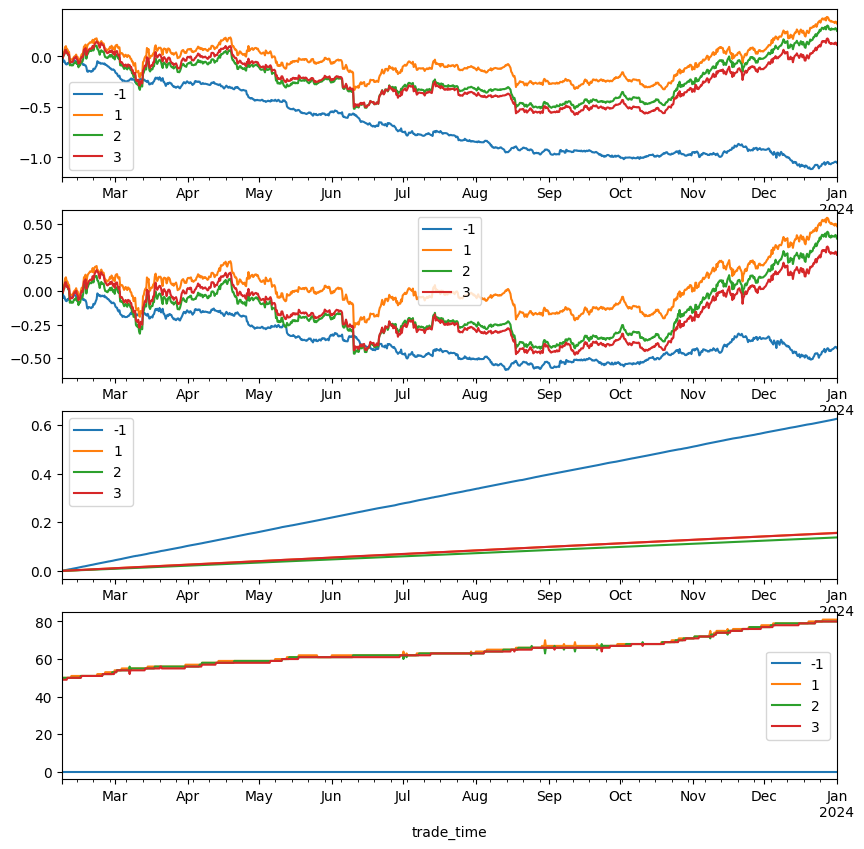

In [19]:
# model.train()
# test_bar = tqdm(test_loader)  # 形成进度条
# y_test_pred_all = np.array([])
# for idx, data in enumerate(test_bar):
#     x_test, y_test = data  # 解包迭代器中的X和Y
#     optimizer.zero_grad()
#     y_test_pred: torch.Tensor = model(x_test)
#     # print(y_test_pred.shape)
#     # total_length += y_test_pred.shape[0]
#     y_test_pred = y_test_pred.mean(dim=1)
#     print(y_test_pred.shape)
#     y_test_pred_all = np.concatenate((y_test_pred_all, y_test_pred.detach().numpy().flatten()))
#     loss = loss_function(y_test_pred, y_test.reshape(-1, 1))
#     loss.backward()
#     optimizer.step()

model.eval()
y_test_pred = model(x_test_tensor)
y_test_pred = y_test_pred.mean(dim=1)
y_test_pred = y_test_pred.detach().numpy().flatten()
# combo_factor
combo_factor = pd.DataFrame(index_test, columns=['trade_time', 'instrument'])
combo_factor['factor_value'] = y_test_pred
combo_factor = combo_factor.sort_values(by=['trade_time', 'instrument'])
print(combo_factor)


result = backtest(combo_factor, 3)
sharpe = cal_sharpe(result[result['grp']==-1]['cumret'])
print(sharpe)
draw(result)